In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def dist(*vec):
    return np.sqrt(vec[0]**2 + vec[1]**2 + vec[2]**2)

def cartesian(*dims):
    return np.array(np.meshgrid(*dims, indexing='ij')).T.reshape(-1, len(dims))

## Rayleigh scattering



In [8]:
def rayleigh_holo(position, center, k, e_r, radius):
    r = (position-center).T
    r = dist(r[0], r[1], r[2])
    z = center[2]
    c = (e_r-1) / (e_r+2) * k**2 * radius**3 / r
    return 2*(1-(z/r)**2)*c*np.cos(k*r) + (1-(z/r)**2)*c**2 #+ 1

## Rayleigh-Gans Approximation to Sphere

Define model function for hologram.

A tip to remember here is that you should avoid "pythonic" idioms involving iterables. While numpy ndarrays, lists, etc, are iterable over their elements, theano objects are not iterable by default because their class structure is not compatible with this notion. In otherwords, you cannot unpack a theano object. You would run into trouble when pymc3 passes they object to your model. This is why I have lines like `re_m, im_m = m[0], m[1]` instead of simply `re_m, im_m = m`... it's because when m is a theano variable that represents two component rather than actually being two components, the interpreter will not know the meaning of the latter.

Also some numpy functions are not supported automatically by theano. (For example, I have to use numpy.arctan instead of numpy.arctan2)

For any scattering process from a symmetric object, the scattered field can be expresed in term of the incident field as

$\begin{pmatrix}E_{\parallel s} \\ E_{\perp s} \end{pmatrix} = \frac{e^{i k (r-z)}}{i k r }\begin{pmatrix} S_2 & 0\\0 & S_1\end{pmatrix} \begin{pmatrix}E_{\parallel i} \\ E_{\perp i} \end{pmatrix}$

For a sphere, the scattering coefficients are 
$\begin{pmatrix}S_1 \\ S_2\end{pmatrix} = i k^3 a^3 (m-1) \frac{2}{3} G(u)\begin{pmatrix}1 \\ \cos\theta\end{pmatrix}$

$G(u) = \left( \frac{9 \pi}{2 u^3}\right)^{1/2}J_{3/2}(u) = \frac{3}{u^3}(\sin u - u \cos u)$ 
Also, here $u = 2 x \sin \frac{\theta}{2}$ where $x = k a$ is the size parameter for incident wavevector k and sphere radius a

Define the incident field as

$$\vec{E}_i = E_0 \hat{x}$$

So that we have :

$$\vec{E}_s =  E_0 \frac{e^{i k (r-z)}}{i k r } S_2(\theta) \hat{x}$$

The irradiance Stokes parameter is

\begin{align}
    I &= \left|\vec{E}_{i} + \vec{E}_{s}\right|^2 \\
    &= \left(\vec{E}_{i} + \vec{E}_{s}\right) \left(\vec{E}_{i} + \vec{E}_{s}\right)^*\\
    &= \left|\vec{E}_{i}\right|^2 + \left|\vec{E}_{s}\right|^2 + \vec{E}_{i} \cdot \vec{E}_{s}^* + \vec{E}_{s} 
        \cdot \vec{E}_{i}^*\\
    &= \left|\vec{E}_{i}\right|^2 + \left|\vec{E}_{s}\right|^2 + 2 \,\mathrm{Re}\left(\vec{E}_{i} \cdot \vec{E}_{s}^*\right)
\end{align}

Where we have:

$\left|\vec{E}_{i}\right|^2 = E_0^2$

and 

$\left|\vec{E}_{s}\right|^2 = \frac{E_0^2}{k^2 r^2}\left|S_2(\theta)\right|^2$

Calculating the cross term:

\begin{align}
    2 \,\mathrm{Re} \left( \vec{E}_{i} \cdot \vec{E}_{s}^*\right) &= 2 \frac{E_0^2}{kr} \,\mathrm{Re} \left( i e^{-i k (r-z)} S_2^* \right)\\
    &= - 2 \frac{E_0^2}{kr} \,\mathrm{Im} \left( e^{-i k (r-z)} \left|S_2\right| e^{-i \delta}\right)\\
    &= 2 \frac{E_0^2}{kr} \left|S_2\right| \sin\left(k(r-z) + \delta\right)
\end{align}

The hologram produced is normalized:

$H = \frac{I}{\left|\vec{E}_i\right|^2}$

so that we get

$H = 1 + \frac{1}{k^2 r^2}\left|S_2(\theta)\right|^2 + 2 \frac{\left|S_2(\theta)\right|}{kr}  \sin\left( k(r-z) + \delta\right)$

In [11]:
def rayleigh_gans_sphere_holo(position, k, center, m, a):
    r = (position - center).T
    r = dist(r[0], r[1], r[2])

    z = center[2]
    theta = np.arccos(z / r)

    x = k * a
    u = 2 * x * np.sin(.5 * theta)
    g = 3 / u ** 3 * (np.sin(u) - u * np.cos(u))

    re_m, im_m = m[0], m[1]

    s2_mag = k ** 3 * a ** 3 * np.sqrt(re_m * re_m + im_m * im_m - 2 * re_m + 1) * 2 / 3 * np.abs(np.cos(theta)) * g
    s2_phase = np.arctan((1 - re_m) / im_m) if im_m != 0 else np.pi / 2

    holo_scatt = (1 / (k * r) * s2_mag) ** 2
    holo_inter = 2 * 1/(k*r) * np.sqrt(s2_mag**2) * np.sin(k*(r-z) + s2_phase)

    holo_full = holo_scatt + holo_inter + 1

    return holo_full

Test holograms:

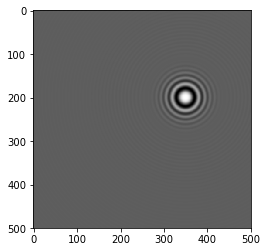

In [12]:
pixel_size = 0.0858
grid_size = 500
x = y = np.linspace(0, pixel_size*grid_size, grid_size)
z = 0

grid = cartesian(x, y, z)

illum_wavelength = .660
illum_wavenumber = 2*np.pi/illum_wavelength
sc_center = np.array([350*pixel_size, 200*pixel_size, 5])
sc_index = np.array([1.4734/1.33, 0])
sc_radius = .5

data = rayleigh_gans_sphere_holo(grid, illum_wavenumber, sc_center, sc_index, sc_radius)
#data = m.add_noise(data, sc=.1)
plt.gray()
plt.imshow(data.reshape((grid_size,grid_size)))
plt.show()